# BlindPaint Example Training Notebook

This Jupyter notebook outlines the general structure used in training the BlindPaint model (our deeply supervised full-scale connected inpainting UNet). Most of the heavy lifting is done in Tensorflow, with submodule imports in the first cell containing the helper methods.

In this example, we will train using a month of data from NSA and OLI (approx. 1.5 GB), already preprocessed and available for download in the following Google Drive folder (https://drive.google.com/drive/folders/1VpVWexR5soQkjcIWsuc6jf-hVBlgtptN?usp=sharing). For additional details preprocessing your own input datasets (i.e. custom radar data) using bp_data_extract_preprocess.py, please refer back to the Methods section of our manuscript for additional details into this step.

We begin by importing the major libraries used in this project (and the corresponding blindpaint submodules).

In [39]:
import random
import numpy as np
import bp_utility
import bp_plotting
import bp_batch
import bp_models
import bp_configs
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as k
from keras.callbacks import History

# Setup random seed
random.seed(0)

We then define some global constants for this example:

In [40]:
data_paths = ['oli_2016_01', 'nsa_2016_01']

# Pattern definition in bp_configs
N_EPOCHS = 5
N_SAMPLES = 5
N_CHANNELS = 5

We can then load the data from our example .npy files using the utility module. Note that we load the raw preprocessed data, valid inpainting indices and a handful of samples to track the model training progress. If we were to apply the trained model on test data, we would also load in the testing data indices by uncommenting the last lines of this cell.

In [41]:
# Training Data
comb_preprocessed, _, _ = bp_utility.data_combiner(data_paths, 'examples/', 'preprocessed', axis=1)
print("\nPreprocessed loaded", comb_preprocessed.shape)

# Valid Indices
comb_indices, DOWNFILL_SAMPLE_INDS, _ = bp_utility.data_combiner(data_paths, 'examples/', 'indices', axis=0)
print("\nIndices loaded", comb_indices.shape)

# Tracking Samples
comb_samples, _, _ = bp_utility.data_combiner(data_paths, 'examples/', 'samples', axis=0)
print("\nSamples loaded", comb_samples.shape)

# Test Sets
# comb_test_set, _, test_breaks = data_combiner(data_paths, 'test_set', axis=0)
# print("\nTest sets loaded", comb_test_set.shape)


Loading: examples/preprocessed/preprocessed_oli_2016_01_kazr.npy
oli_2016_01 (128, 580608, 5)
Loading: examples/preprocessed/preprocessed_nsa_2016_01_kazr.npy
nsa_2016_01 (128, 602112, 5)

Preprocessed loaded (128, 1182720, 5)
Loading: examples/indices/indices_oli_2016_01_kazr.npy
oli_2016_01 (234148,)
Loading: examples/indices/indices_nsa_2016_01_kazr.npy
nsa_2016_01 (242723,)
offset 242723

Indices loaded (476871,)
Loading: examples/samples/samples_oli_2016_01_kazr.npy
Loading: examples/samples/samples_nsa_2016_01_kazr.npy
nsa_2016_01 (78, 128, 128, 6)

Samples loaded (78, 128, 128, 6)


Let's take a look at what some of this data looks like. I've extracted a few samples from the testing dataset in comb_samples, and we can plot the target images for these below. 

Case 5
Case 33
Case 49
Case 53
Case 65


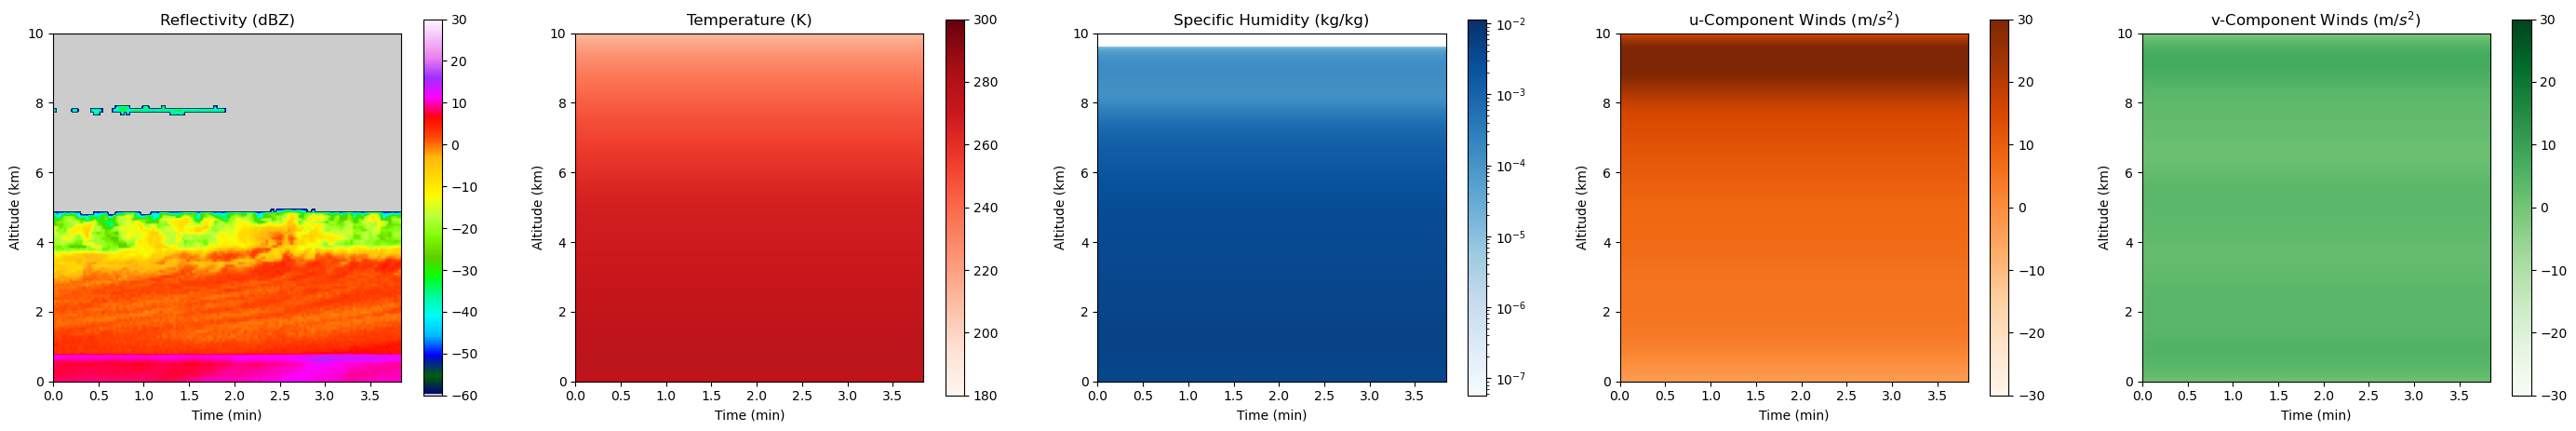

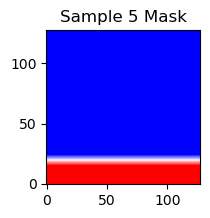

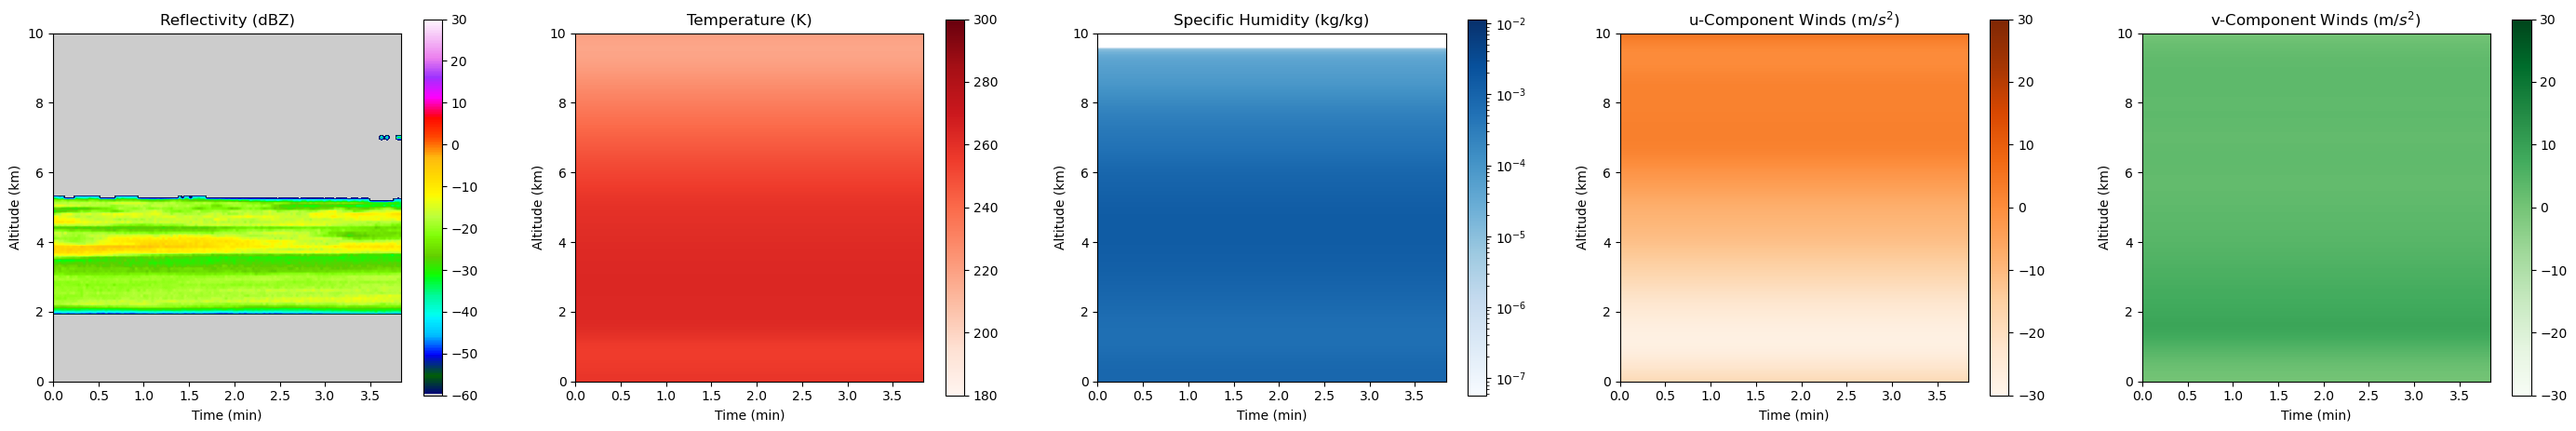

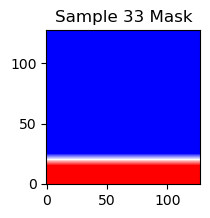

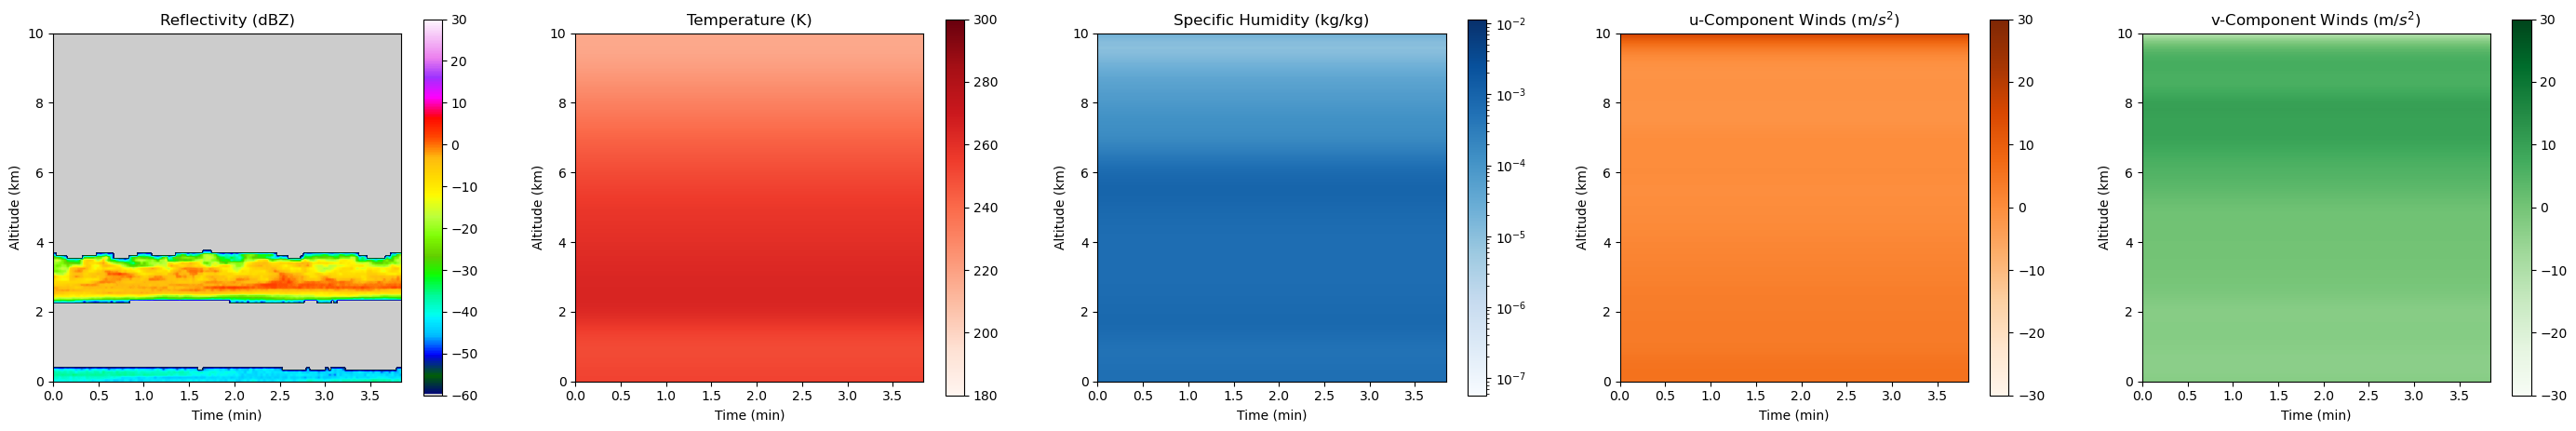

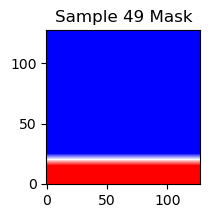

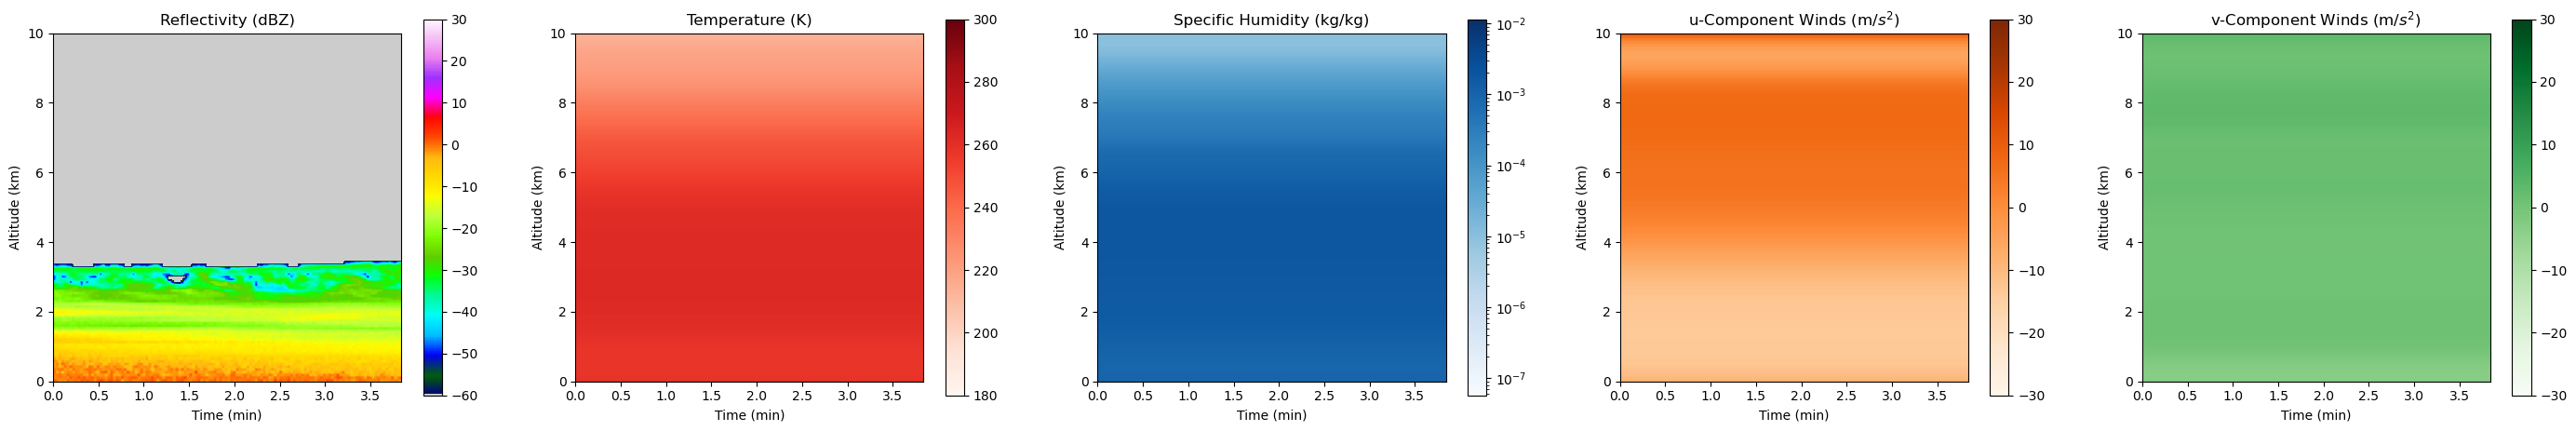

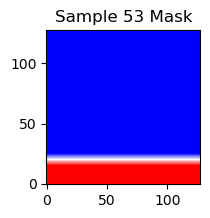

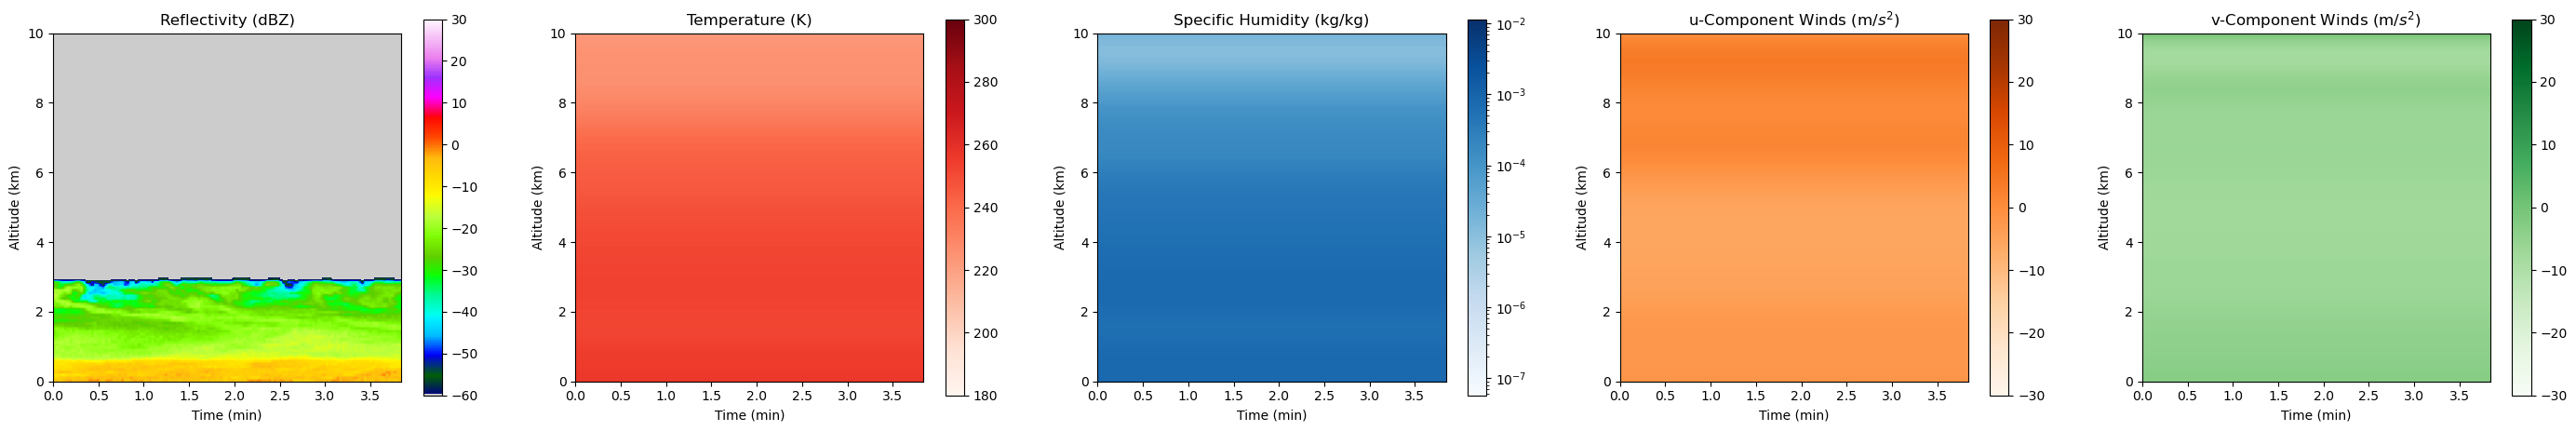

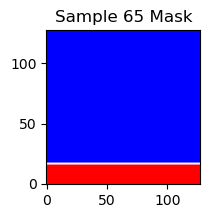

In [42]:
# Helper function for viewing samples
def print_samples(case, show):
    x_samples = comb_samples
    for i,x in enumerate(x_samples):
        if i in show:
            print("Case", i)
            bp_plotting.plot(x[:,:,:5], case)
            fig = plt.figure(figsize=(2,2))
            plt.imshow(np.double(x[:,:,5]), cmap="bwr")
            plt.title("Sample " + str(i) + " Mask")
            plt.gca().invert_yaxis()

show_samples = random.sample(range(len(comb_samples)), N_SAMPLES)

print_samples(comb_samples, show_samples)

Next, let's create our model training function. We are going to be using a bunch of submodules here to load in the 3Net+ architecture and perform a simple training pass on our example data.

In [43]:
history = History()

config_defaults = bp_configs.config_defaults
cnn = bp_models.unet3plus((*bp_configs.SIZE['downfill'],N_CHANNELS+1), N_CHANNELS, \
                            config=config_defaults, depth=config_defaults['depth'], training=False, clm=False)
cnn.summary()

Model: "UNet3Plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 128, 128, 6) 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_36 (Sl (None, 128, 128)     0           input_layer[0][0]                
__________________________________________________________________________________________________
tf.math.floor_2 (TFOpLambda)    (None, 128, 128)     0           tf.__operators__.getitem_36[0][0]
__________________________________________________________________________________________________
tf.__operators__.getitem_37 (Sl (None, 128, 128)     0           input_layer[0][0]                
__________________________________________________________________________________________

While we load the model directly from bp_models in the previous cell, we also include a formal definition of the 3Net+ below for those interested in seeing the architecture in more detail:

In [44]:
def unet3plus(input_shape, output_channels, config, depth=4, training=False):
    """ Prep """
    interp = config['interpolation']
    input_layer = k.layers.Input(shape=input_shape, name="input_layer")
    xpre = bp_models.preprocess(input_layer, output_channels)

    """ Encoder """
    encoders = []
    for i in range(depth+1):
        if i == 0:
            e = bp_models.conv_block(xpre, config['filters']*(2**i), 
                                     kernel_size=(config['kernel_size'], config['kernel_size']), 
                                     l2_reg=config['l2_reg'])
        else:
            e = k.layers.MaxPool2D(pool_size=(2, 2))(encoders[i-1])
            e = k.layers.Dropout(config['dropout'])(e, training=True)
            e = bp_models.conv_block(e, config['filters']*(2**i), 
                                     kernel_size=(config['kernel_size'], config['kernel_size']), 
                                     l2_reg=config['l2_reg'])

        encoders.append(e)

    """ Middle """
    cat_channels = config['filters']
    cat_blocks = depth+1
    upsample_channels = cat_blocks * cat_channels

    """ Decoder """
    decoders = []
    for d in reversed(range(depth+1)):
        if d == 0 :
            continue
        loc_dec = []
        decoder_pos = len(decoders)
        for e in range(len(encoders)):
            if d > e+1:
                e_d = k.layers.MaxPool2D(pool_size=(2**(d-e-1), 2**(d-e-1)))(encoders[e])
                e_d = k.layers.Dropout(config['dropout'])(e_d, training=True)
                e_d = bp_models.conv_block(e_d, cat_channels, kernel_size=(config['kernel_size'], 
                                                                 config['kernel_size']), n=1, 
                                                                 l2_reg=config['l2_reg'])
            elif d == e+1:
                e_d = bp_models.conv_block(encoders[e], cat_channels, kernel_size=(config['kernel_size'], 
                                                                         config['kernel_size']), n=1, 
                                                                         l2_reg=config['l2_reg'])
            elif e+1 == len(encoders):
                e_d = k.layers.UpSampling2D(size=(2**(e+1-d), 2**(e+1-d)), 
                                            interpolation=interp)(encoders[e])
                e_d = k.layers.Dropout(config['dropout'])(e_d, training=True)
                e_d = bp_models.conv_block(e_d, cat_channels, kernel_size=(config['kernel_size'], 
                                                                 config['kernel_size']), n=1, 
                                                                 l2_reg=config['l2_reg'])
            else:
                e_d = k.layers.UpSampling2D(size=(2**(e+1-d), 2**(e+1-d)), 
                                            interpolation=interp)(decoders[decoder_pos-1])
                e_d = k.layers.Dropout(config['dropout'])(e_d, training=True)
                e_d = bp_models.conv_block(e_d, cat_channels, kernel_size=(config['kernel_size'], 
                                                                 config['kernel_size']), n=1, 
                                                                 l2_reg=config['l2_reg'])
                decoder_pos -= 1
            loc_dec.append(e_d)
        de = k.layers.concatenate(loc_dec)
        de = bp_models.conv_block(de, upsample_channels, kernel_size=(config['kernel_size'], 
                                                            config['kernel_size']), n=1, 
                                                            l2_reg=config['l2_reg'])
        decoders.append(de)

    """ Final """
    d1 = decoders[len(decoders)-1]
    d1 = bp_models.conv_block(d1, output_channels, 
                              kernel_size=(config['kernel_size'], config['kernel_size']),
                    n=1, is_bn=False, is_relu=False, l2_reg=config['l2_reg'])
    outputs = [d1]

    """ Deep Supervision """
    if training:
        for i in reversed(range(len(decoders))):
            if i == 0:
                e = bp_models.conv_block(encoders[len(encoders)-1], output_channels, 
                                         kernel_size=(config['kernel_size'], config['kernel_size']), n=1,
                                           is_bn=False, is_relu=False, l2_reg=config['l2_reg'])
                e = k.layers.UpSampling2D(size=(2**(len(decoders)-i), 2**(len(decoders)-i)), 
                                          interpolation=interp)(e)
                outputs.append(e)
            else:
                d = bp_models.conv_block(decoders[i - 1], output_channels, 
                                         kernel_size=(config['kernel_size'], config['kernel_size']), n=1, 
                                         is_bn=False, is_relu=False, l2_reg=config['l2_reg'])
                d = k.layers.UpSampling2D(size=(2**(len(decoders)-i), 2**(len(decoders)-i)), 
                                          interpolation=interp)(d)
                outputs.append(d)

    """ Classifier and Deep Supervision Cont'd """
    if training:
        for i in range(len(outputs)):
            if i == 0:
                continue
            d_e = outputs[i]
            outputs[i] = bp_models.merge_output(input_layer, k.activations.linear(d_e), output_channels)

    return tf.keras.Model(inputs=input_layer, outputs=outputs, name='UNet3Plus')

Next we need to compile the model (defining its loss and metrics tracking), and set up the minibatch generators.

In [45]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config_defaults['lr']), loss=bp_models.blind_MAE, metrics=[bp_models.dice_coef])
batch = bp_batch.BATCH_FUNC['downfill']
data = comb_preprocessed[:,:,:bp_configs.CHANNELS]
x_samples = comb_samples[:,:,:,:bp_configs.CHANNELS+1]
x = np.zeros((250*config_defaults['batch_size'], *bp_configs.SIZE['downfill'], N_CHANNELS+1), dtype='float16')

print("Model compiled successfully!")

Model compiled successfully!


Finally, with everything set up we can run the training loop (and print out the inpainted samples as shown above). Note, in this example, 5 epochs is insufficient to fully reconstruct these regions so performance will not be great. This is merely to demonstrate how a training run can be accomplished.

Epoch 0:
Epoch batch shape (4000, 128, 128, 6)
238/238 [==============================] - 35s 129ms/step - loss: 0.3885 - dice_coef: 0.6579 - val_loss: 0.3160 - val_dice_coef: 0.7062
Epoch 1:
Epoch batch shape (4000, 128, 128, 6)
238/238 [==============================] - 40s 166ms/step - loss: 0.2691 - dice_coef: 0.6707 - val_loss: 0.2584 - val_dice_coef: 0.6721
Epoch 2:
Epoch batch shape (4000, 128, 128, 6)
238/238 [==============================] - 61s 255ms/step - loss: 0.2464 - dice_coef: 0.6787 - val_loss: 0.2332 - val_dice_coef: 0.7232
Epoch 3:
Epoch batch shape (4000, 128, 128, 6)
238/238 [==============================] - 38s 159ms/step - loss: 0.2390 - dice_coef: 0.6659 - val_loss: 0.2042 - val_dice_coef: 0.7297
Epoch 4:
Epoch batch shape (4000, 128, 128, 6)
238/238 [==============================] - 41s 174ms/step - loss: 0.2322 - dice_coef: 0.6654 - val_loss: 0.2115 - val_dice_coef: 0.6529


d:\Development\blindpaint\bp_plotting.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=[FWID, FWID*0.8])


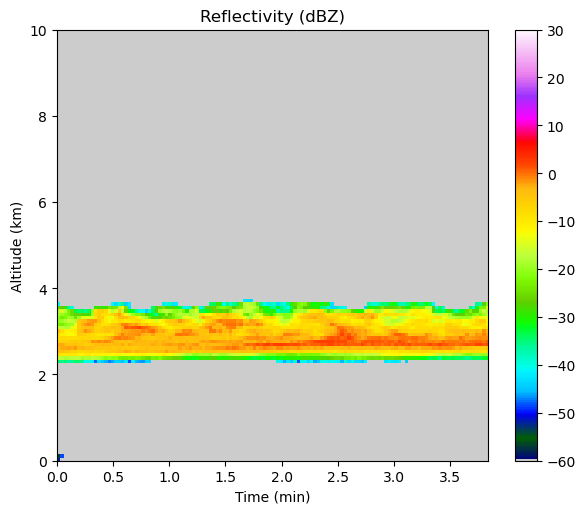

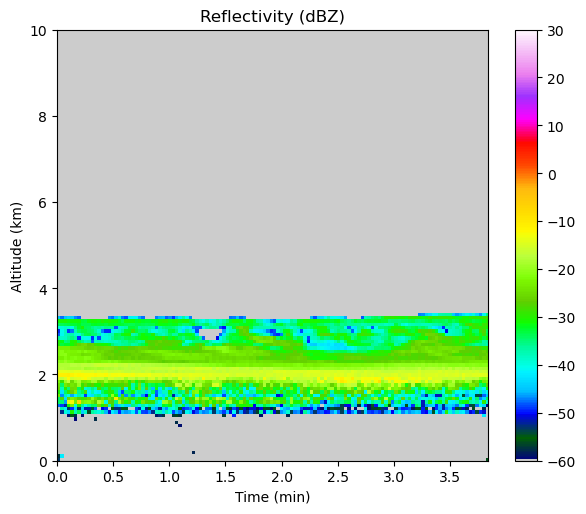

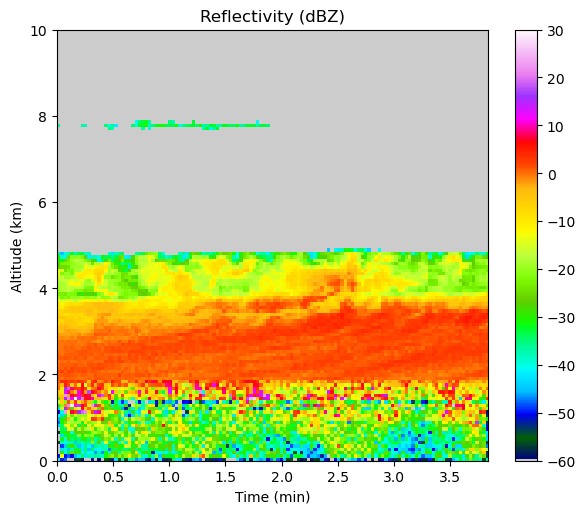

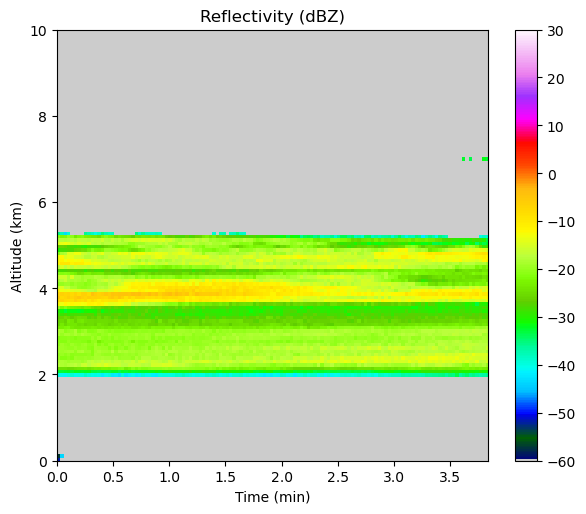

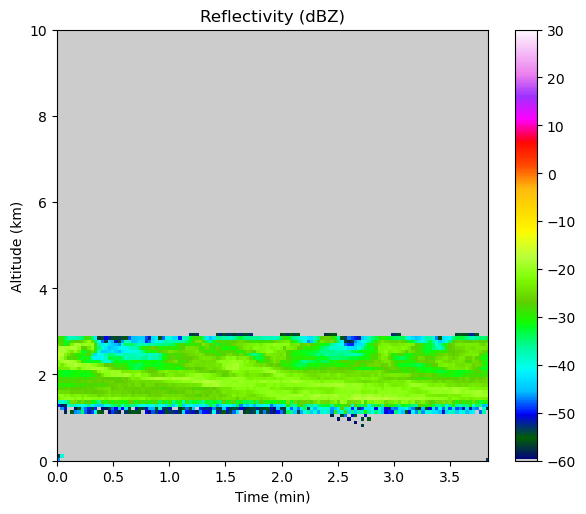

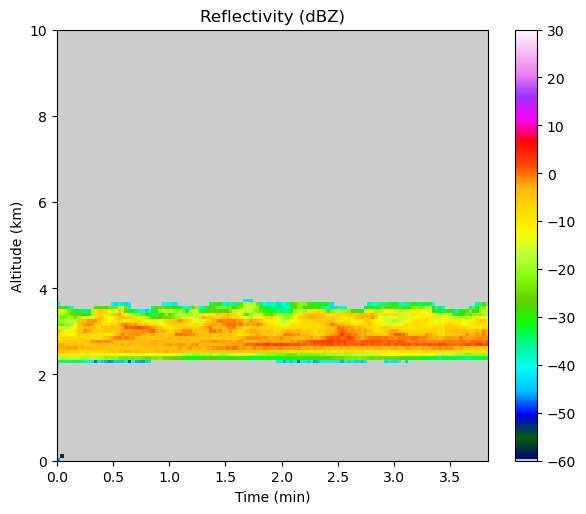

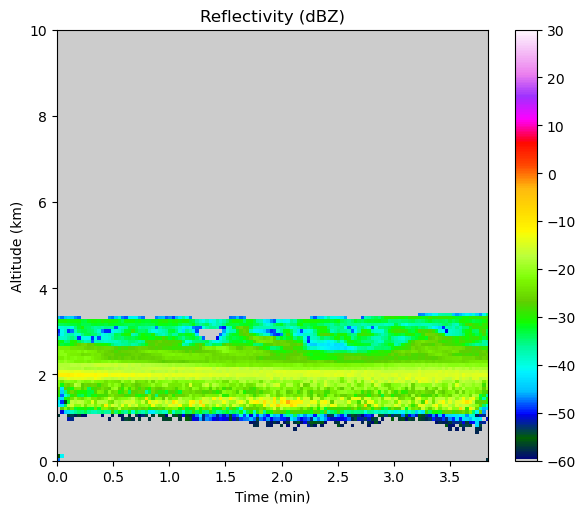

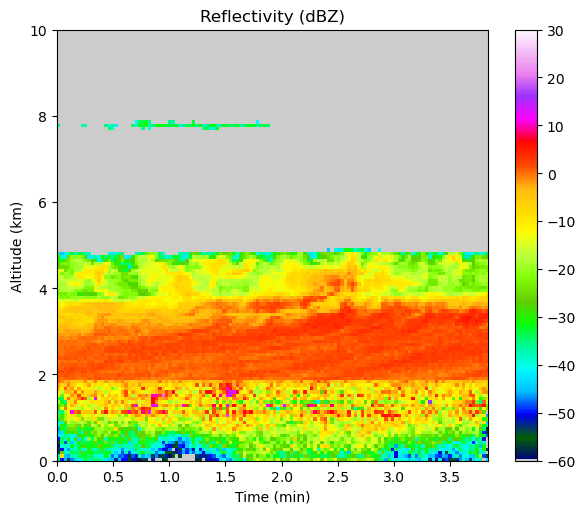

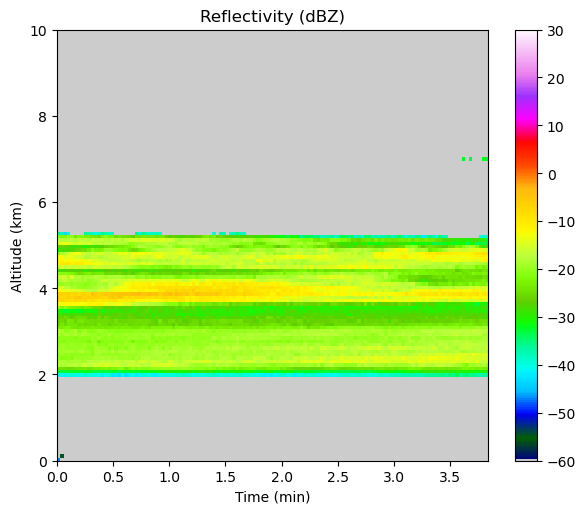

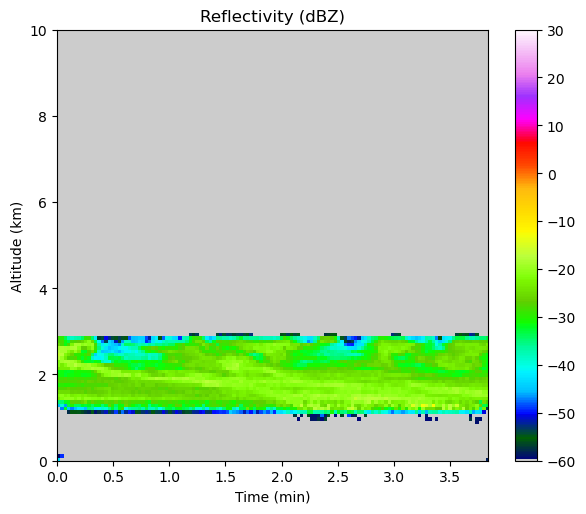

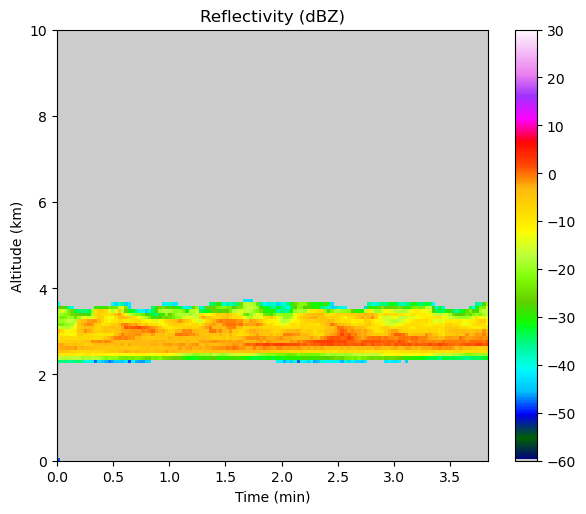

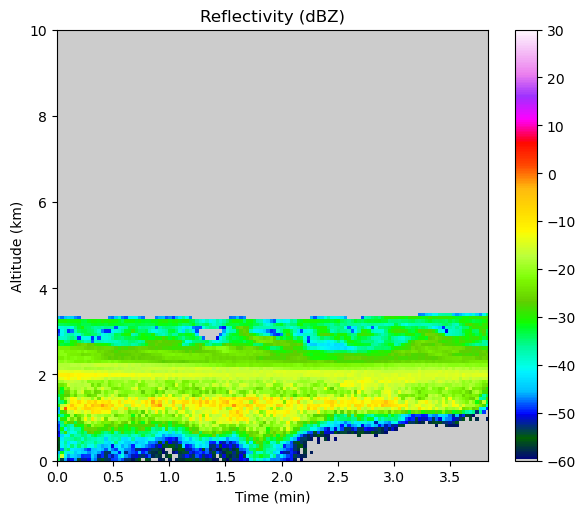

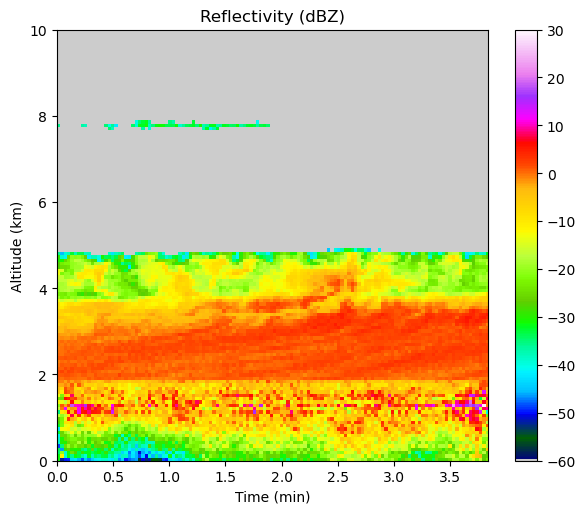

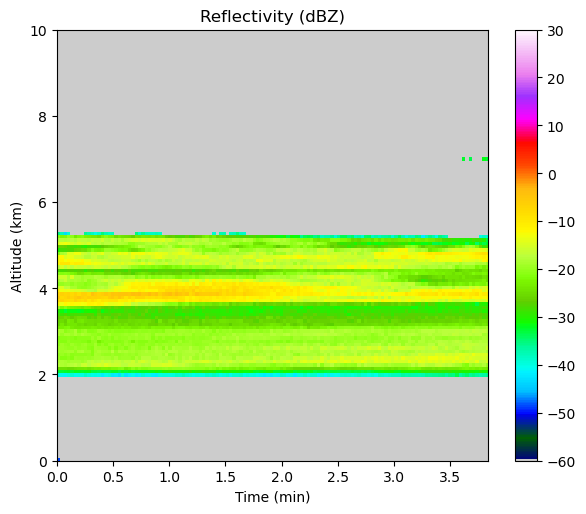

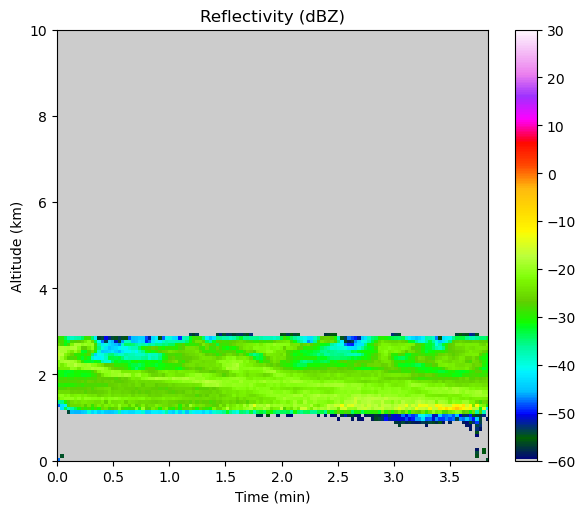

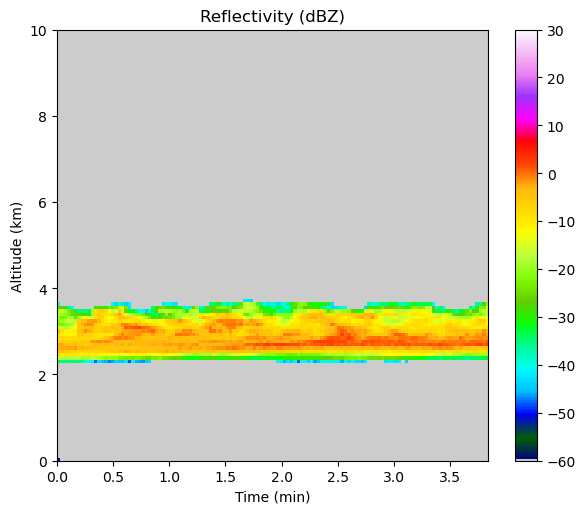

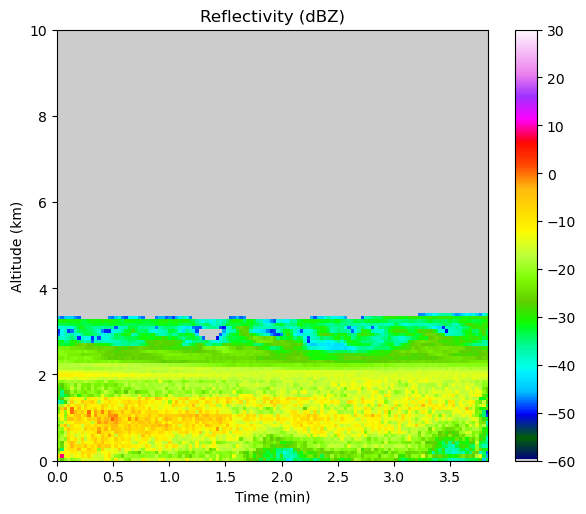

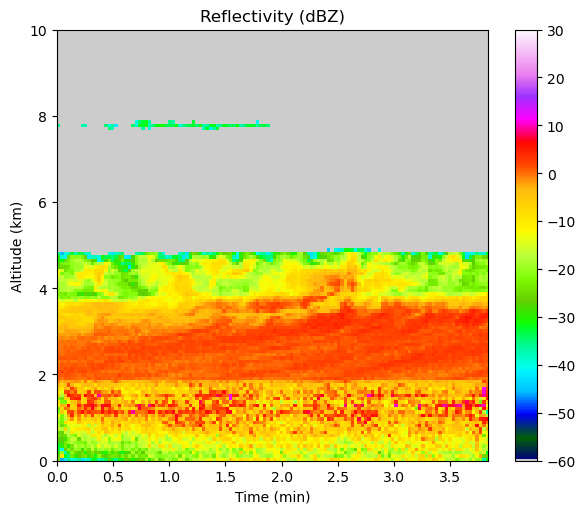

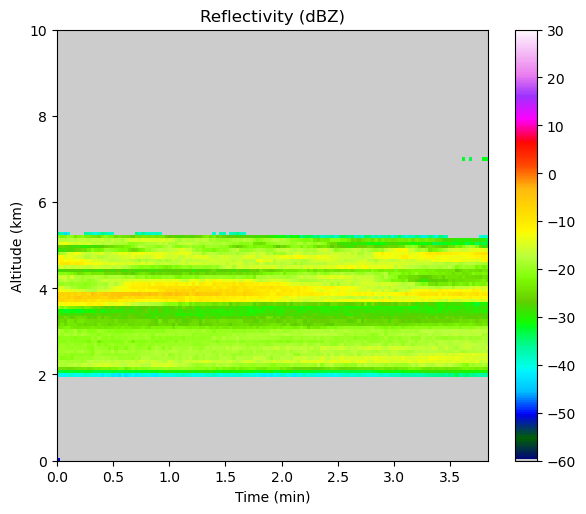

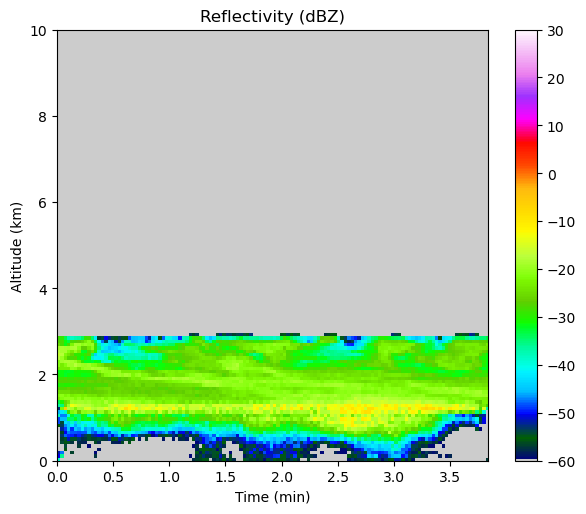

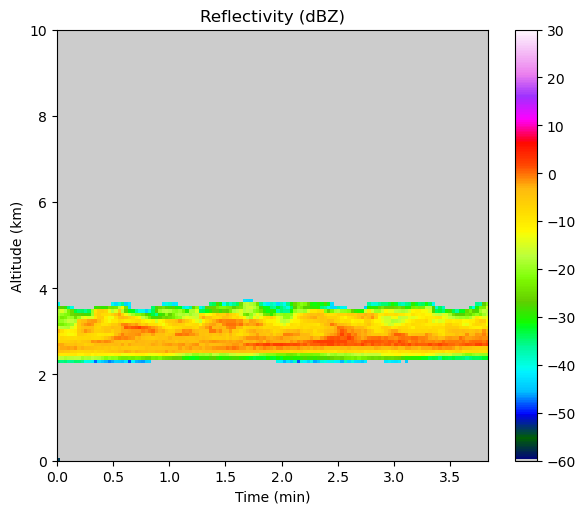

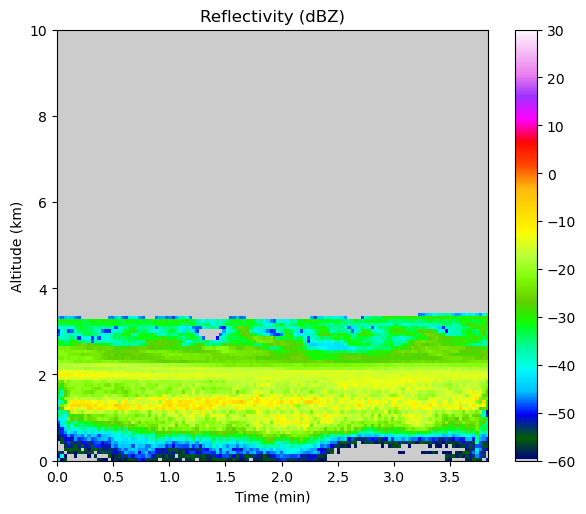

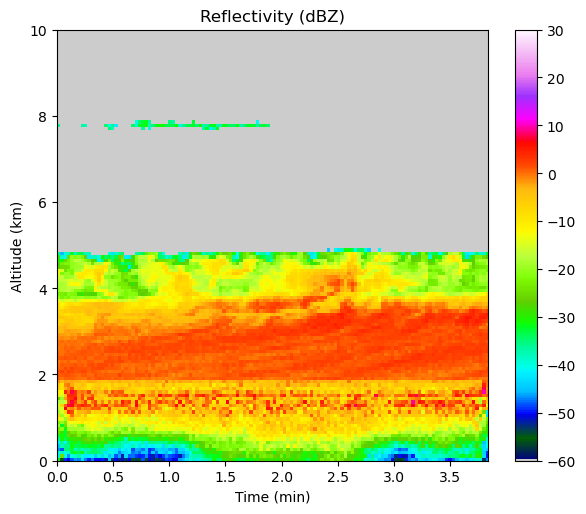

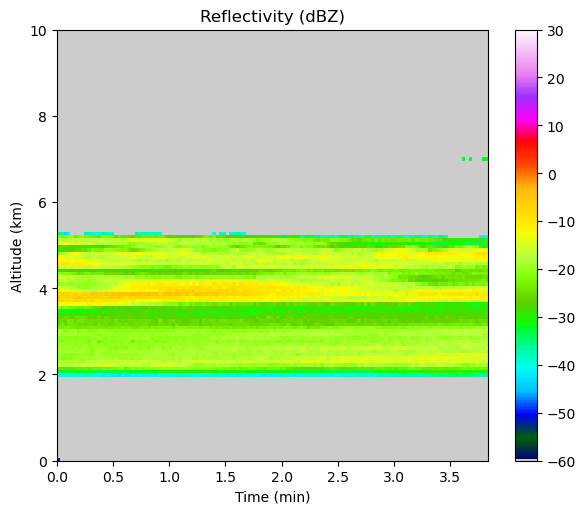

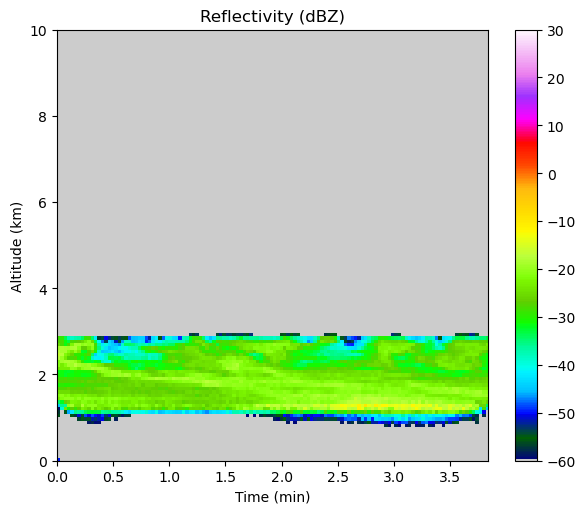

In [46]:
for epoch in range(N_EPOCHS):
    print('Epoch ' + str(epoch) + ':')
    
    batch(x, data, sample_inds = DOWNFILL_SAMPLE_INDS)
    print('Epoch batch shape', x.shape)

    # Model fit
    cnn.fit(x, x, batch_size=config_defaults['batch_size'], verbose=1, validation_split=0.05, callbacks=[history])

    # Prediction
    outputs = cnn.predict(x_samples, batch_size=config_defaults['batch_size'])
    for i in range(N_CHANNELS):
        outputs[:,:,:,i][outputs[:,:,:,0]<bp_configs.CLOUD_MASK] = -1.0
    
    for i in show_samples:
        bp_plotting.plot(outputs[i,:,:,0], 'downfill')




With training complete, you can then save the model (or save checkpoint along the way in the training loop) and begin applying it to the test data to see how well the model generalizes. For more details into this process, please refer back to the manuscript and review the bp_drop_eval and bp_test_all submodules.

In [47]:
print("All done!")

All done!
